# Imports

In [329]:
# ==========================================
# Basic Libraries
# ==========================================
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import display, HTML

# ==========================================
# Scikit-learn General
# ==========================================
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import make_pipeline

# ==========================================
# Scikit-learn Preprocessing & Transformation
# ==========================================
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel, RFECV

# ==========================================
# Scikit-learn Regressors
# ==========================================
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# ==========================================
# External Regressors & Libraries
# ==========================================
import xgboost as xgb
from xgboost import XGBRegressor

# ==========================================
# Miscellaneous Settings
# ==========================================
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [330]:
houses = pd.read_csv('/Users/merlesteffen/Documents/GitHub/HousingPricePrediction/Data/Kaggle_Data/house-prices-advanced-regression-techniques/train.csv')

In [331]:
houses.drop(columns=['Id'], inplace=True)

In [332]:
houses['MSSubClass'] = houses['MSSubClass'].astype('object')
#Changing OverallCond into a categorical variable
houses['OverallCond'] = houses['OverallCond'].astype('object')

In [333]:
# Outliers
houses.drop(houses[houses['GrLivArea'] >= 4000].index, inplace=True)

In [334]:
# Skewed Data#

In [335]:
numerical_cols = [cname for cname in houses.columns if houses[cname].dtypes!='object' and cname!='SalePrice']
skew_df = pd.DataFrame(numerical_cols, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(houses[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)

In [336]:
#Apply log1p transformation
for column in skew_df.query("Skewed == True")['Feature'].values:
    houses[column] = np.log1p(houses[column])

# Split Data

In [337]:
X = houses.copy()
X.drop(columns='SalePrice', inplace=True)
y = np.log1p(houses['SalePrice'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Missing Values

In [338]:
# Temporarily set the display options to show all rows
pd.set_option('display.max_rows', None)

# Display the NaN counts for all columns
print(X_train.isna().sum())

# Reset the display options back to default settings
pd.reset_option('display.max_rows')

MSSubClass          0
MSZoning            0
LotFrontage       221
LotArea             0
Street              0
Alley            1094
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          5
MasVnrArea          5
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           30
BsmtCond           30
BsmtExposure       31
BsmtFinType1       30
BsmtFinSF1          0
BsmtFinType2       30
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea 

In [339]:
# After inspection we find that where there is not fireplace fireplacequ was set to missing instead of 'NA'
X_train.loc[X_train['Fireplaces'] == 0, 'FireplaceQu'] = 'NA'

In [340]:
garage_null_rows = X_train[X_train['GarageCond'].isnull()]

# Display just the garage-related columns for these rows
garage_columns = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']
garage_null_rows[garage_columns]

# Let us reset the columns to 'NA'

# List of columns to update
cols_to_update = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

# Set those columns to 'NA' where GarageArea is 0
X_train.loc[X_train['GarageArea'] == 0, cols_to_update] = 'NA'
X_train.loc[X_train['GarageArea'] == 0, 'GarageYrBlt'] = -9999

In [341]:
pool_null_rows = X_train[X_train['PoolQC'].isnull()]

# Display just the pool-related columns for these rows
pool_columns = ['PoolArea', 'PoolQC']
pool_null_rows[pool_columns]

# Just as I thought, let us replace the missing values with 'NA'
X_train.loc[X_train['PoolArea'] == 0, 'PoolQC'] = 'NA'

In [342]:
# Let us check the Fence
X_train[X_train['Fence'] == 'NA']
X_train['Fence'].fillna('NA', inplace=True)

In [343]:
# MiscFeature
X_train[X_train['MiscFeature'] == 'NA']
X_train['MiscFeature'].fillna('NA', inplace=True)

In [344]:
# Alley
X_train[X_train['Alley'] == 'NA']
X_train['Alley'].fillna('NA', inplace=True)

In [345]:
# Doesnt work for LotFrontage so it will be needed to use SimpleImputer

In [346]:
# Electrical we dont know, so since it is only one observation

In [347]:
# All Basement Columns
no_basement_rows = X_train[X_train['TotalBsmtSF'] == 0]

# Define the list of basement-related columns
bsmt_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 
                'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']

# Display the values in the basement-related columns for these rows
no_basement_rows[bsmt_columns]

# List of columns to update based on your provided list
bsmt_columns_to_update = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

X_train.loc[X_train['TotalBsmtSF'] == 0, bsmt_columns_to_update] = 'NA'

In [348]:
# MasVnrType & MasVnrArea have each five missing values, which are in the same observations, 
# so I will experiment around with this, maybe drop them or impute them, we will see.

In [349]:
# Calculate variance
variance = X_train.var()

# Sort variance from lowest to highest
sorted_variance = variance.sort_values()

# Round to 5 decimal places and format to display in full
formatted_variance = sorted_variance.round(5).apply(lambda x: '{:.5f}'.format(x))

print(formatted_variance)

YearBuilt              0.00024
KitchenAbvGr           0.00823
BsmtHalfBath           0.02741
TotRmsAbvGrd           0.04414
1stFlrSF               0.09670
GrLivArea              0.10349
HalfBath               0.11717
BsmtFullBath           0.12190
Fireplaces             0.15275
PoolArea               0.17469
LotArea                0.26383
FullBath               0.30163
LowQualFinSF           0.49255
3SsnPorch              0.50681
GarageCars             0.55128
BedroomAbvGr           0.66209
OverallCond            1.22695
MiscVal                1.66648
YrSold                 1.76874
OverallQual            1.86967
ScreenPorch            1.99055
EnclosedPorch          2.84623
BsmtUnfSF              3.34477
BsmtFinSF2             3.44430
OpenPorchSF            4.61791
WoodDeckSF             6.74926
MoSold                 7.25700
BsmtFinSF1             8.90990
2ndFlrSF              10.82425
YearRemodAdd         428.48146
LotFrontage          548.05704
MSSubClass          1769.91404
MasVnrAr

### Correlation

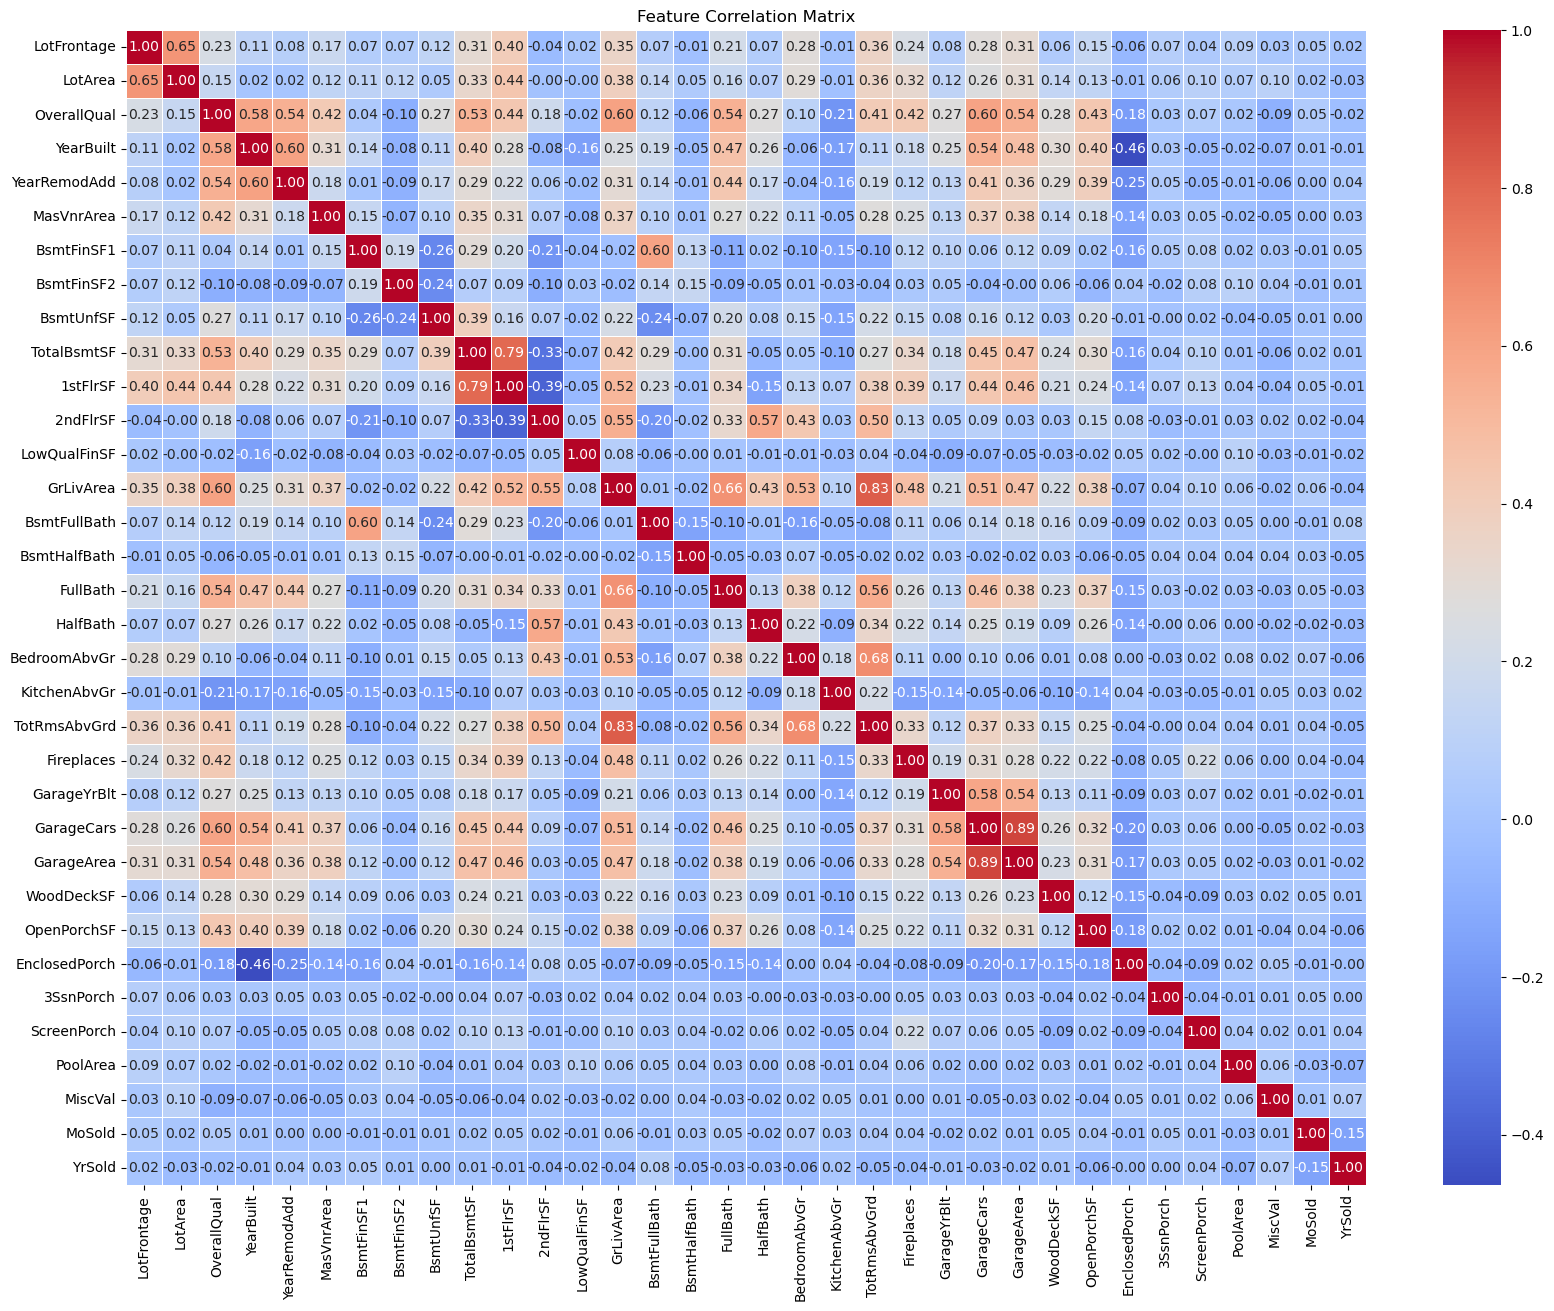

In [350]:
# Compute the correlation matrix
corr = X_train.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# Generate a heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='white')

plt.title('Feature Correlation Matrix')
plt.show()

Maybe drop Garage Cars, since it has the lower Variance and is highly correlated with Garage Area.
The Rest looks great.

## Independent Vriable Normalize

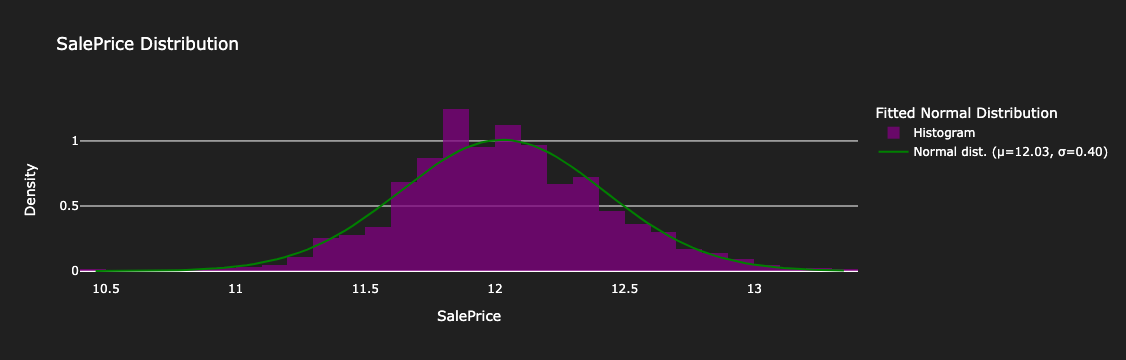

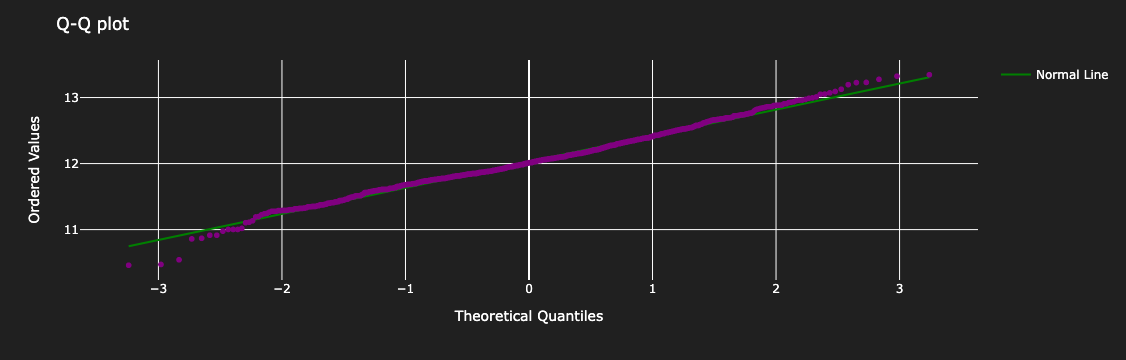

In [351]:
import scipy.stats as stats

# Fit a normal distribution to the SalePrice data
mu, sigma = stats.norm.fit(y_train)

# Create a histogram of the SalePrice column
hist_data = go.Histogram(x=y_train, nbinsx=50, name="Histogram", opacity=0.75, histnorm='probability density', marker=dict(color='purple'))

# Calculate the normal distribution based on the fitted parameters
x_norm = np.linspace(y_train.min(), y_train.max(), 100)
y_norm = stats.norm.pdf(x_norm, mu, sigma)

# Create the normal distribution overlay
norm_data = go.Scatter(x=x_norm, y=y_norm, mode="lines", name=f"Normal dist. (μ={mu:.2f}, σ={sigma:.2f})", line=dict(color="green"))

# Combine the histogram and the overlay
fig = go.Figure(data=[hist_data, norm_data])

# Set the layout for the plot
fig.update_layout(
    title="SalePrice Distribution",
    xaxis_title="SalePrice",
    yaxis_title="Density",
    legend_title_text="Fitted Normal Distribution",
    plot_bgcolor='rgba(32, 32, 32, 1)',
    paper_bgcolor='rgba(32, 32, 32, 1)',
    font=dict(color='white')
)

# Create a Q-Q plot
qq_data = stats.probplot(y_train, dist="norm")
qq_fig = px.scatter(x=qq_data[0][0], y=qq_data[0][1], labels={'x': 'Theoretical Quantiles', 'y': 'Ordered Values'}, color_discrete_sequence=["purple"])
qq_fig.update_layout(
    title="Q-Q plot",
    plot_bgcolor='rgba(32, 32, 32, 1)',
    paper_bgcolor='rgba(32, 32, 32, 1)',
    font=dict(color='white')
)

# Calculate the line of best fit
slope, intercept, r_value, p_value, std_err = stats.linregress(qq_data[0][0], qq_data[0][1])
line_x = np.array(qq_data[0][0])
line_y = intercept + slope * line_x

# Add the line of best fit to the Q-Q plot
line_data = go.Scatter(x=line_x, y=line_y, mode="lines", name="Normal Line", line=dict(color="green"))

# Update the Q-Q plot with the normal line
qq_fig.add_trace(line_data)

# Show the plots
fig.show()
qq_fig.show()

Use Log Transformation later on since the Data are skewed.

# Preprocess Data

 Let us remember the LotFrontage is the only one with missing values.

In [352]:
num_features = X_train.select_dtypes(exclude=['object']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

## Encoding

In [353]:
# Define orders
order_ExterQual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_ExterCond = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtQual = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtCond = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtExposure = ['NA', 'No', 'Mn', 'Av', 'Gd']
order_BsmtFinType1 = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
order_BsmtFinType2 = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
order_HeatingQC = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_KitchenQual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_Functional = ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']
order_FireplaceQu = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_GarageFinish = ['NA', 'Unf', 'RFn', 'Fin']
order_GarageQual = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_GarageCond = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_PavedDrive = ['N', 'P', 'Y']
order_PoolQC = ['NA', 'Fa', 'TA', 'Gd', 'Ex']
order_Fence = ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']

# Setup the encoder
ordinal_enc = OrdinalEncoder(
    categories=[
        order_ExterQual, order_ExterCond, order_BsmtQual, order_BsmtCond, 
        order_BsmtExposure, order_BsmtFinType1, order_BsmtFinType2, order_HeatingQC, 
        order_KitchenQual, order_Functional, order_FireplaceQu, order_GarageFinish, order_GarageQual, 
        order_GarageCond, order_PavedDrive, order_PoolQC, order_Fence
    ],
    handle_unknown='use_encoded_value',
    unknown_value=-1
)


In [354]:
cat_ordinal = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
    'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 
    'GarageCond', 'PavedDrive', 'PoolQC', 'Fence'
]
cat_onehot = [col for col in cat_features if col not in cat_ordinal]

## Pipelines

### Select From Model

In [355]:
num_pipeline = make_pipeline(
    SimpleImputer(strategy='mean')
)

cat_ordinal_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    ordinal_enc
)

cat_onehot_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
)

In [356]:
preprocessor = ColumnTransformer(transformers=[
    ('num_pipe', num_pipeline, num_features),
    ('onehot', cat_onehot_pipe, cat_onehot),
    ('ordinal', cat_ordinal_pipe, cat_ordinal)
])

In [357]:
# feature engineering functions 
def custom_features(df):
    df_out = df.copy()
    df_out['PropertyAge'] = df_out['YrSold'] - df_out['YearBuilt']
    df_out['TotalSF'] = df_out['TotalBsmtSF'] + df_out['1stFlrSF'] + df_out['2ndFlrSF']
    df_out['TotalBath'] = df_out['FullBath'] + 0.5 * df_out['HalfBath'] + df_out['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
    df_out['HasRemodeled'] = (df_out['YearRemodAdd'] != df_out['YearBuilt']).astype(object)
    df_out['Has2ndFloor'] = (df_out['2ndFlrSF'] > 0).astype(object)
    df_out['HasGarage'] = (df_out['GarageArea'] > 0).astype(object)
    df_out['YrSold_cat'] = df_out['YrSold'].astype(object)
    df_out['MoSold_cat'] = df_out['MoSold'].astype(object)
    df_out['YearBuilt_cat'] = df_out['YearBuilt'].astype(object)
    df_out['MSSubClass_cat'] = df_out['MSSubClass'].astype(object)
    
    return df_out

feature_engineering_transformer = FunctionTransformer(custom_features)

## GradientBoostingRegressor

In [322]:
# Best Model so far
model_GBR =  GradientBoostingRegressor(n_estimators=1100, loss='squared_error', subsample = 0.35, learning_rate = 0.05,random_state=1)
GBR_Pipeline = make_pipeline(feature_engineering_transformer, preprocessor, StandardScaler(), model_GBR)
GBR_Pipeline.fit(X_train, y_train)
preds_GBR = GBR_Pipeline.predict(X_test)

predictions = GBR_Pipeline.predict(X_test)
mae = mean_absolute_error(y_true=y_test, y_pred=predictions).round(2)
rmse = mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)
mape = mean_absolute_percentage_error(y_true=y_test, y_pred=predictions)
r2 = r2_score(y_true=y_test, y_pred=predictions)

model_df = pd.DataFrame({
    "MAE": [mae],
    "RMSE": [rmse],
    "MAPE": [mape],
    "R2": [r2]},
)
model_df

MAE      RMSE      MAPE       R2
0  0.08  0.128353  0.007041  0.89569

#### Submitting

In [78]:
new_data = pd.read_csv('/Users/merlesteffen/Documents/GitHub/HousingPricePrediction/Data/Kaggle_Data/house-prices-advanced-regression-techniques/test.csv')
id_col = new_data.pop('Id')

In [79]:
new_data['MSSubClass'] = new_data['MSSubClass'].astype('object')
houses['OverallCond'] = houses['OverallCond'].astype('object')

In [28]:
GBR_Pipeline.fit(X,y)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function custom_features at 0x2ae9b1ee0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtS...
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'KitchenQual', 'FireplaceQu',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PoolQC',
                                                   'Fence'])])),
                ('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=4,
                                           min_samples_leaf=3,
                                           n_estimators=1200, random_state=1,
                                           subsample=0.35))])

In [30]:
prices_log = GBR_Pipeline.predict(new_data)
prices = np.expm1(prices_log)
prices

In [32]:
submission_file = pd.DataFrame({
    'Id':id_col,
    'SalePrice':prices
})
submission_file

Id      SalePrice
0     1461  126582.183082
1     1462  158068.364259
2     1463  182399.835732
3     1464  190542.523598
4     1465  189938.056346
...    ...            ...
1454  2915   81944.346958
1455  2916   80389.032134
1456  2917  161125.973645
1457  2918  117429.395181
1458  2919  223138.929728

[1459 rows x 2 columns]

In [33]:
submission_file.to_csv('/Users/merlesteffen/Documents/GitHub/HousingPricePrediction/Data/Submissions/submission_new.csv',index=False)

## Grid Search

In [80]:
# Define the parameter grid
param_grid = {
    'gradientboostingregressor__n_estimators': [1000, 1100, 1200],
    'gradientboostingregressor__learning_rate': [0.01, 0.05, 0.1],
    'gradientboostingregressor__subsample': [0.3, 0.35, 0.4],
    'gradientboostingregressor__max_depth': [3, 4, 5],
    'gradientboostingregressor__min_samples_split': [2, 3, 4],
    'gradientboostingregressor__min_samples_leaf': [1, 2, 3]
    # Add more parameters if needed
}

# Create the grid search object
grid_search = GridSearchCV(GBR_Pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-2, verbose=1)

# Fit to the data
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict using the best model
predictions = best_model.predict(X_test)
mae = mean_absolute_error(y_true=y_test, y_pred=predictions).round(2)
rmse = mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)
mape = mean_absolute_percentage_error(y_true=y_test, y_pred=predictions)
r2 = r2_score(y_true=y_test, y_pred=predictions)

model_df = pd.DataFrame({
    "MAE": [mae],
    "RMSE": [rmse],
    "MAPE": [mape],
    "R2": [r2]},
)
model_df


Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was rename

MAE      RMSE      MAPE        R2
0  0.08  0.125663  0.007057  0.900017

# Submitting

In [81]:
new_data = pd.read_csv('/Users/merlesteffen/Documents/GitHub/HousingPricePrediction/Data/Kaggle_Data/house-prices-advanced-regression-techniques/test.csv')
id_col = new_data.pop('Id')

In [82]:
new_data['MSSubClass'] = new_data['MSSubClass'].astype('object')
houses['OverallCond'] = houses['OverallCond'].astype('object')

In [83]:
best_model.fit(X,y)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function custom_features at 0x176b8dc60>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtS...
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'KitchenQual', 'Functional',
                                                   'FireplaceQu',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive',
                                                   'PoolQC', 'Fence'])])),
                ('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=5,
                                           min_samples_leaf=3,
                                           n_estimators=1200, random_state=1,
                                           subsample=0.3))])

In [84]:
prices_log = best_model.predict(new_data)
prices = np.expm1(prices_log)
prices

array([126897.6106895 , 160561.08813429, 183538.38883829, ...,
       159126.67348622, 115773.15796704, 216252.31621061])

In [85]:
submission_file = pd.DataFrame({
    'Id':id_col,
    'SalePrice':prices
})
submission_file

Id      SalePrice
0     1461  126897.610689
1     1462  160561.088134
2     1463  183538.388838
3     1464  187611.884236
4     1465  192756.742723
...    ...            ...
1454  2915   79652.936508
1455  2916   79608.642478
1456  2917  159126.673486
1457  2918  115773.157967
1458  2919  216252.316211

[1459 rows x 2 columns]

In [86]:
submission_file.to_csv('/Users/merlesteffen/Documents/GitHub/HousingPricePrediction/Data/Submissions/submission_new.csv',index=False)

## XGBoost Regressor

In [388]:
## Create the XGBRegressor model
xgboost_params = {
    'n_estimators': 5000,
    'learning_rate': 0.02,
    'colsample_bytree': 0.5,
    'subsample': 0.5,
    'min_child_weight': 4
}

model_XGB= XGBRegressor(**xgboost_params)
XGB_Pipeline = make_pipeline(feature_engineering_transformer, preprocessor, StandardScaler(), model_XGB)
XGB_Pipeline.fit(X_train, y_train, xgbregressor__eval_metric="rmse")


# Predict using the best model
predictions_xgb = XGB_Pipeline.predict(X_test)
mae_xgb = mean_absolute_error(y_true=y_test, y_pred=predictions_xgb).round(2)
rmse_xgb = mean_squared_error(y_true=y_test, y_pred=predictions_xgb, squared=False)
# MAPE doesn't exist in scikit-learn by default, but assuming you've defined it as before:
mape_xgb = mean_absolute_percentage_error(y_true=y_test, y_pred=predictions_xgb)
r2_xgb = r2_score(y_true=y_test, y_pred=predictions_xgb)

model_df_xgb = pd.DataFrame({
    "MAE": [mae_xgb],
    "RMSE": [rmse_xgb],
    "MAPE": [mape_xgb],
    "R2": [r2_xgb]},
)
model_df_xgb

MAE     RMSE      MAPE        R2
0  0.08  0.12237  0.006861  0.905188

## Randomized Grid

In [392]:
random_param_grid = {
    'xgbregressor__n_estimators': [1000, 2500, 5000, 7500, 10000],
    'xgbregressor__learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
    'xgbregressor__colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'xgbregressor__subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'xgbregressor__min_child_weight': [1, 2, 4, 6, 8, 10]
}


# Create the XGBRegressor model
model_XGB = xgb.XGBRegressor(random_state=1)
XGB_Pipeline = make_pipeline(feature_engineering_transformer, preprocessor, StandardScaler(), model_XGB)


# Create the grid search object for XGBRegressor
grid_search_xgb = RandomizedSearchCV(XGB_Pipeline, random_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-2, verbose=2)

# Fit to the data
grid_search_xgb.fit(X_train, y_train)

# Get the best model
best_model_xgb = grid_search_xgb.best_estimator_

# Predict using the best model
predictions_xgb = best_model_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_true=y_test, y_pred=predictions_xgb).round(2)
rmse_xgb = mean_squared_error(y_true=y_test, y_pred=predictions_xgb, squared=False)
# MAPE doesn't exist in scikit-learn by default, but assuming you've defined it as before:
mape_xgb = mean_absolute_percentage_error(y_true=y_test, y_pred=predictions_xgb)
r2_xgb = r2_score(y_true=y_test, y_pred=predictions_xgb)

model_df_xgb = pd.DataFrame({
    "MAE": [mae_xgb],
    "RMSE": [rmse_xgb],
    "MAPE": [mape_xgb],
    "R2": [r2_xgb]},
)
model_df_xgb

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was rename

MAE      RMSE     MAPE        R2
0  0.08  0.124373  0.00687  0.902059

#### Grid Search

In [393]:
grid_param_grid = {
    'xgbregressor__n_estimators': [4900, 5000, 5100],
    'xgbregressor__learning_rate': [0.018, 0.02, 0.022],
    'xgbregressor__colsample_bytree': [0.48, 0.5, 0.52],
    'xgbregressor__subsample': [0.48, 0.5, 0.52],
    'xgbregressor__min_child_weight': [3, 4, 5]
}

# Create the XGBRegressor model
model_XGB = xgb.XGBRegressor(random_state=1)
XGB_Pipeline = make_pipeline(feature_engineering_transformer, preprocessor, StandardScaler(), model_XGB)


# Create the grid search object for XGBRegressor
grid_search_xgb = GridSearchCV(XGB_Pipeline, grid_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-2, verbose=2)

# Fit to the data
grid_search_xgb.fit(X_train, y_train)

# Get the best model
best_model_xgb = grid_search_xgb.best_estimator_

# Predict using the best model
predictions_xgb = best_model_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_true=y_test, y_pred=predictions_xgb).round(2)
rmse_xgb = mean_squared_error(y_true=y_test, y_pred=predictions_xgb, squared=False)
# MAPE doesn't exist in scikit-learn by default, but assuming you've defined it as before:
mape_xgb = mean_absolute_percentage_error(y_true=y_test, y_pred=predictions_xgb)
r2_xgb = r2_score(y_true=y_test, y_pred=predictions_xgb)

model_df_xgb = pd.DataFrame({
    "MAE": [mae_xgb],
    "RMSE": [rmse_xgb],
    "MAPE": [mape_xgb],
    "R2": [r2_xgb]},
)
model_df_xgb

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was rename

[CV] END xgbregressor__colsample_bytree=0.7, xgbregressor__learning_rate=0.01, xgbregressor__min_child_weight=8, xgbregressor__n_estimators=1000, xgbregressor__subsample=0.4; total time=   3.0s
[CV] END xgbregressor__colsample_bytree=0.5, xgbregressor__learning_rate=0.05, xgbregressor__min_child_weight=8, xgbregressor__n_estimators=2500, xgbregressor__subsample=0.4; total time=   6.9s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.05, xgbregressor__min_child_weight=1, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.5; total time=  11.6s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.05, xgbregressor__min_child_weight=1, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.5; total time=  10.6s
[CV] END xgbregressor__colsample_bytree=0.3, xgbregressor__learning_rate=0.01, xgbregressor__min_child_weight=1, xgbregressor__n_estimators=2500, xgbregressor__subsample=0.8; total time=   5.2s
[CV] END xgbregressor__colsamp

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [10, 14, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and

[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.005, xgbregressor__min_child_weight=1, xgbregressor__n_estimators=1000, xgbregressor__subsample=0.3; total time=   2.0s
[CV] END xgbregressor__colsample_bytree=0.5, xgbregressor__learning_rate=0.05, xgbregressor__min_child_weight=8, xgbregressor__n_estimators=2500, xgbregressor__subsample=0.4; total time=   6.9s
[CV] END xgbregressor__colsample_bytree=0.4, xgbregressor__learning_rate=0.05, xgbregressor__min_child_weight=10, xgbregressor__n_estimators=7500, xgbregressor__subsample=0.7; total time=  15.7s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__min_child_weight=4, xgbregressor__n_estimators=10000, xgbregressor__subsample=0.5; total time=  46.6s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.018, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.5; total time=  20.4s
[CV] END xgbregressor__co

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [11, 17, 18, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [10, 14, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_ou

[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.005, xgbregressor__min_child_weight=1, xgbregressor__n_estimators=1000, xgbregressor__subsample=0.3; total time=   1.9s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.05, xgbregressor__min_child_weight=10, xgbregressor__n_estimators=7500, xgbregressor__subsample=0.3; total time=  26.5s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__min_child_weight=4, xgbregressor__n_estimators=10000, xgbregressor__subsample=0.5; total time=  44.4s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.018, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.48; total time=  20.1s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.018, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.48; total time=  20.2s
[CV] END xgbregressor

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [6, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [10, 14, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is 

[CV] END xgbregressor__colsample_bytree=0.7, xgbregressor__learning_rate=0.01, xgbregressor__min_child_weight=8, xgbregressor__n_estimators=1000, xgbregressor__subsample=0.4; total time=   3.0s
[CV] END xgbregressor__colsample_bytree=0.3, xgbregressor__learning_rate=0.001, xgbregressor__min_child_weight=8, xgbregressor__n_estimators=1000, xgbregressor__subsample=0.6; total time=   0.7s
[CV] END xgbregressor__colsample_bytree=0.3, xgbregressor__learning_rate=0.001, xgbregressor__min_child_weight=8, xgbregressor__n_estimators=1000, xgbregressor__subsample=0.6; total time=   0.7s
[CV] END xgbregressor__colsample_bytree=0.3, xgbregressor__learning_rate=0.001, xgbregressor__min_child_weight=8, xgbregressor__n_estimators=1000, xgbregressor__subsample=0.6; total time=   0.7s
[CV] END xgbregressor__colsample_bytree=0.3, xgbregressor__learning_rate=0.001, xgbregressor__min_child_weight=8, xgbregressor__n_estimators=1000, xgbregressor__subsample=0.6; total time=   0.7s
[CV] END xgbregressor__col

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 17, 21, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [10, 14, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_out

[CV] END xgbregressor__colsample_bytree=0.7, xgbregressor__learning_rate=0.01, xgbregressor__min_child_weight=8, xgbregressor__n_estimators=1000, xgbregressor__subsample=0.4; total time=   3.0s
[CV] END xgbregressor__colsample_bytree=0.5, xgbregressor__learning_rate=0.05, xgbregressor__min_child_weight=8, xgbregressor__n_estimators=2500, xgbregressor__subsample=0.4; total time=   6.8s
[CV] END xgbregressor__colsample_bytree=0.4, xgbregressor__learning_rate=0.05, xgbregressor__min_child_weight=10, xgbregressor__n_estimators=7500, xgbregressor__subsample=0.7; total time=  12.4s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__min_child_weight=4, xgbregressor__n_estimators=10000, xgbregressor__subsample=0.5; total time=  41.1s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.018, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.48; total time=  13.9s
[CV] END xgbregressor__co

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [11, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [11, 17, 18, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.005, xgbregressor__min_child_weight=1, xgbregressor__n_estimators=1000, xgbregressor__subsample=0.3; total time=   1.9s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.05, xgbregressor__min_child_weight=10, xgbregressor__n_estimators=7500, xgbregressor__subsample=0.3; total time=  23.7s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__min_child_weight=4, xgbregressor__n_estimators=10000, xgbregressor__subsample=0.5; total time=  41.0s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.018, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.48; total time=  14.0s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.018, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.52; total time=  14.2s
[CV] END xgbregressor

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [6, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [10, 14, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 17, 21, 25] during transform. These unknown categories will be e

[CV] END xgbregressor__colsample_bytree=0.7, xgbregressor__learning_rate=0.01, xgbregressor__min_child_weight=8, xgbregressor__n_estimators=1000, xgbregressor__subsample=0.4; total time=   3.0s
[CV] END xgbregressor__colsample_bytree=0.5, xgbregressor__learning_rate=0.05, xgbregressor__min_child_weight=8, xgbregressor__n_estimators=2500, xgbregressor__subsample=0.4; total time=   6.8s
[CV] END xgbregressor__colsample_bytree=0.4, xgbregressor__learning_rate=0.05, xgbregressor__min_child_weight=10, xgbregressor__n_estimators=7500, xgbregressor__subsample=0.7; total time=  12.2s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.05, xgbregressor__min_child_weight=1, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.5; total time=   9.1s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__min_child_weight=2, xgbregressor__n_estimators=7500, xgbregressor__subsample=0.6; total time=  21.6s
[CV] END xgbregressor__colsa

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [6, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [11, 17, 18, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output`

[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.005, xgbregressor__min_child_weight=1, xgbregressor__n_estimators=1000, xgbregressor__subsample=0.3; total time=   2.0s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.05, xgbregressor__min_child_weight=10, xgbregressor__n_estimators=7500, xgbregressor__subsample=0.3; total time=  27.1s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__min_child_weight=2, xgbregressor__n_estimators=7500, xgbregressor__subsample=0.6; total time=  26.4s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.018, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.5; total time=  14.1s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.018, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.48; total time=  14.1s
[CV] END xgbregressor_

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [6, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [11, 17, 18, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output`

[CV] END xgbregressor__colsample_bytree=0.7, xgbregressor__learning_rate=0.01, xgbregressor__min_child_weight=8, xgbregressor__n_estimators=1000, xgbregressor__subsample=0.4; total time=   3.0s
[CV] END xgbregressor__colsample_bytree=0.5, xgbregressor__learning_rate=0.05, xgbregressor__min_child_weight=8, xgbregressor__n_estimators=2500, xgbregressor__subsample=0.4; total time=   6.9s
[CV] END xgbregressor__colsample_bytree=0.4, xgbregressor__learning_rate=0.05, xgbregressor__min_child_weight=10, xgbregressor__n_estimators=7500, xgbregressor__subsample=0.7; total time=  11.7s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.05, xgbregressor__min_child_weight=1, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.5; total time=   9.6s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__min_child_weight=2, xgbregressor__n_estimators=7500, xgbregressor__subsample=0.6; total time=  22.0s
[CV] END xgbregressor__colsa

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [10, 14, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 17, 21, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_out

[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.005, xgbregressor__min_child_weight=1, xgbregressor__n_estimators=1000, xgbregressor__subsample=0.3; total time=   1.9s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.05, xgbregressor__min_child_weight=10, xgbregressor__n_estimators=7500, xgbregressor__subsample=0.3; total time=  27.0s
[CV] END xgbregressor__colsample_bytree=0.6, xgbregressor__learning_rate=0.001, xgbregressor__min_child_weight=2, xgbregressor__n_estimators=7500, xgbregressor__subsample=0.6; total time=  26.4s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.018, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.52; total time=  14.0s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.018, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.52; total time=  14.0s
[CV] END xgbregressor

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [11, 17, 18, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 17, 21, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse

[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.05, xgbregressor__min_child_weight=10, xgbregressor__n_estimators=7500, xgbregressor__subsample=0.3; total time=  26.2s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__learning_rate=0.01, xgbregressor__min_child_weight=4, xgbregressor__n_estimators=10000, xgbregressor__subsample=0.5; total time=  44.8s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.018, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.5; total time=  20.3s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.018, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.5; total time=  20.7s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.018, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=5100, xgbregressor__subsample=0.48; total time=  18.8s
[CV] END xgbregressor

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 17, 21, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [11, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_out

[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=4, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.48; total time=  17.4s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=4, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.48; total time=  13.7s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=4, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.52; total time=  14.2s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=4, xgbregressor__n_estimators=5100, xgbregressor__subsample=0.48; total time=  14.6s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=5, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.48; total time=  14.6s
[CV] END xgbreg

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 17, 21, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [11, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [6, 16] during transform. These unknown categories will be e

[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.02, xgbregressor__min_child_weight=5, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.5; total time=  21.5s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.02, xgbregressor__min_child_weight=5, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.52; total time=  15.6s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.02, xgbregressor__min_child_weight=5, xgbregressor__n_estimators=5100, xgbregressor__subsample=0.5; total time=  15.7s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.48; total time=  13.6s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.52; total time=  14.0s
[CV] END xgbregresso

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [11, 17, 18, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [10, 14, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_ou

[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.02, xgbregressor__min_child_weight=5, xgbregressor__n_estimators=5100, xgbregressor__subsample=0.52; total time=  20.7s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.52; total time=  18.3s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.52; total time=  19.9s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=5100, xgbregressor__subsample=0.5; total time=  18.9s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=4, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.52; total time=  19.5s
[CV] END xgbregre

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [10, 14, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.018, xgbregressor__min_child_weight=5, xgbregressor__n_estimators=5100, xgbregressor__subsample=0.48; total time=  19.6s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.02, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.48; total time=  17.6s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.02, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.52; total time=  17.4s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.02, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.52; total time=  20.7s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.02, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=5100, xgbregressor__subsample=0.52; total time=  23.0s
[CV] END xgbregress

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 17, 21, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [11, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_out

[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.02, xgbregressor__min_child_weight=5, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.52; total time=  21.4s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.02, xgbregressor__min_child_weight=5, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.52; total time=  20.2s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.02, xgbregressor__min_child_weight=5, xgbregressor__n_estimators=5100, xgbregressor__subsample=0.5; total time=  20.1s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.5; total time=  15.9s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.5; total time=  13.7s
[CV] END xgbregressor

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [6, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 17, 21, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [11, 17, 18, 21] during transform. These unknown categories will 

[CV] END xgbregressor__colsample_bytree=0.5, xgbregressor__learning_rate=0.018, xgbregressor__min_child_weight=5, xgbregressor__n_estimators=5100, xgbregressor__subsample=0.48; total time=  21.8s
[CV] END xgbregressor__colsample_bytree=0.5, xgbregressor__learning_rate=0.02, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.48; total time=  14.5s
[CV] END xgbregressor__colsample_bytree=0.5, xgbregressor__learning_rate=0.02, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.48; total time=  14.8s
[CV] END xgbregressor__colsample_bytree=0.5, xgbregressor__learning_rate=0.02, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.52; total time=  15.4s
[CV] END xgbregressor__colsample_bytree=0.5, xgbregressor__learning_rate=0.02, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=5100, xgbregressor__subsample=0.5; total time=  15.1s
[CV] END xgbregressor__co

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 17, 21, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [6, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` 

[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.52; total time=  19.2s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=4, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.48; total time=  18.3s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=4, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.52; total time=  18.9s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=4, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.52; total time=  18.2s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=4, xgbregressor__n_estimators=5100, xgbregressor__subsample=0.52; total time=  15.0s
[CV] END xgbreg

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [9, 17, 21, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.52; total time=  19.8s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=5100, xgbregressor__subsample=0.52; total time=  18.9s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=4, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.52; total time=  19.4s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=4, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.5; total time=  20.3s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.022, xgbregressor__min_child_weight=4, xgbregressor__n_estimators=5100, xgbregressor__subsample=0.52; total time=  14.7s
[CV] END xgbregr

/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [11, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [6, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is 

MAE      RMSE      MAPE        R2
0  0.08  0.124705  0.006818  0.901535

### Submitting

In [394]:
new_data = pd.read_csv('/Users/merlesteffen/Documents/GitHub/HousingPricePrediction/Data/Kaggle_Data/house-prices-advanced-regression-techniques/test.csv')
id_col = new_data.pop('Id')

In [395]:
new_data['MSSubClass'] = new_data['MSSubClass'].astype('object')
new_data['OverallCond'] = new_data['OverallCond'].astype('object')

In [400]:
best_model_xgb.fit(X,y)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function custom_features at 0x2d2726f20>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtS...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.02,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=3, missing=nan,
                              monotone_constraints=None, n_estimators=5000,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=1, ...))])

In [401]:
prices_log = best_model_xgb.predict(new_data)
prices = np.expm1(prices_log)
prices

array([201525.36, 250069.88, 278774.  , ..., 266260.5 , 207170.55,
       306944.7 ], dtype=float32)

In [402]:
submission_file = pd.DataFrame({
    'Id':id_col,
    'SalePrice':prices
})
submission_file

Id      SalePrice
0     1461  201525.359375
1     1462  250069.875000
2     1463  278774.000000
3     1464  317130.343750
4     1465  342280.281250
...    ...            ...
1454  2915  159771.984375
1455  2916  162615.859375
1456  2917  266260.500000
1457  2918  207170.546875
1458  2919  306944.687500

[1459 rows x 2 columns]

[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.02, xgbregressor__min_child_weight=3, xgbregressor__n_estimators=5100, xgbregressor__subsample=0.48; total time=  21.8s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.02, xgbregressor__min_child_weight=4, xgbregressor__n_estimators=4900, xgbregressor__subsample=0.5; total time=  14.7s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.02, xgbregressor__min_child_weight=4, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.48; total time=  14.6s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.02, xgbregressor__min_child_weight=4, xgbregressor__n_estimators=5000, xgbregressor__subsample=0.52; total time=  15.1s
[CV] END xgbregressor__colsample_bytree=0.48, xgbregressor__learning_rate=0.02, xgbregressor__min_child_weight=4, xgbregressor__n_estimators=5100, xgbregressor__subsample=0.52; total time=  15.2s
[CV] END xgbregressor

In [399]:
submission_file.to_csv('/Users/merlesteffen/Documents/GitHub/HousingPricePrediction/Data/Submissions/submission_new_xgb2.csv',index=False)

# Regression Stacking

In [324]:
# Define parameter grid
# You can define specific parameters for your base models and the meta-regressor
param_grid = {
    'stackingregressor__rf__n_estimators': [10, 100],
    'stackingregressor__xgb__learning_rate': [0.01, 0.1],
    'stackingregressor__final_estimator__alpha': [0.1, 1.0, 10.0]  # parameters for Ridge
}

# Initialize GridSearchCV with the scoring method set to 'neg_mean_squared_error'
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Fit the grid search
grid.fit(X_train, y_train)

# Get the best pipeline
best_pipeline = grid.best_estimator_

# Predict using the best pipeline
y_pred = best_pipeline.predict(X_test)

predictions = best_pipeline.predict(X_test)
mae = mean_absolute_error(y_true=y_test, y_pred=predictions).round(2)
rmse = mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)
mape = mean_absolute_percentage_error(y_true=y_test, y_pred=predictions)
r2 = r2_score(y_true=y_test, y_pred=predictions)

model_df = pd.DataFrame({
    "MAE": [mae],
    "RMSE": [rmse],
    "MAPE": [mape],
    "R2": [r2]},
)
model_df

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was rename

MAE      RMSE      MAPE        R2
0  0.09  0.129976  0.007434  0.893036

# The End

In [36]:
print('This is the End, you know. Lady the plans we had went all wrong! We aint nothing but a ??? went all wrong!')

This is the End, you know. Lady the plans we had went all wrong! We aint nothing but a ??? went all wrong!
